## Mouse hippocampal data within circular track

In [9]:
import sys, os, time
import numpy as np
import scipy.io as io
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE
from sklearn.model_selection import KFold
import sklearn.metrics.pairwise as mtr
import umap

import NMLfunc as nml

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Plotting parameters
sns.set(style='ticks',font_scale=2)
AXIS_LIM = 1
colb = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']
plt.set_cmap('hsv') # circular cmap
# make svg text editable in illustrator
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [6]:
# Set working paths
codeDir = os.getcwd()
len2del = len(codeDir.split('/')[-1])
homeDir = codeDir[:-len2del]
figDir = homeDir+'/figures'
figDirSim = figDir+'/03_Figure_sim_manifold'
figDirReal = figDir+'/02_Figure_real_manifold'
figDirAD = figDir+'/04_Figure_AD_manifold'
realDir = homeDir+'dataset/m62_fov2_fam1nov-fam1_STAR'
simPath = homeDir+'dataset/simulation_Control_and_AD.mat'
dataDir = homeDir+'dataset/'

## Load Data

In [7]:
TYP = 1 # 0 to load sim data, 1 to load real ones

# reconstruction parameters
K_lle = 10
LAMBDA = 1

# global parameters
DIMS = 5
AXIS_LIM = 1

# Load data
ds_plt = 1 # downsample for plotting
down = 3 # downsampling param for manifold embedding
LBL = 'real'
print('Loading real data...')
for d,folder,files in os.walk(realDir):
    continue
file = [s for s in files if 'Track' in s]
temp = io.loadmat(realDir+'/'+file[0])
phi = temp['phi']; x = temp['x']; y = temp['y']; r = temp['r']
speed = temp['speed']; Time = temp['time']
file = [s for s in files if 'spikes' in s]
temp = io.loadmat(realDir+'/'+file[0])
spikes = temp['spikes']
params = temp['params']
file = [s for s in files if 'fissa' in s]
temp = io.loadmat(realDir+'/'+file[0])
dff =  temp['ddf_f']
    
# find  active times
speed_thr = 20
active = speed.flatten() > speed_thr
print('Active samples:%s - Immobility samples:%s'%(sum(active),sum(~active)))
plt.plot(speed); plt.ylabel('Speed [mm/s]')
# filter neural activity for active times only
dff_og = dff.copy() # save the full activity
dff = dff[:,active]
phi_og = phi.copy() # save the full phi
phi = phi[active].flatten()
    
# initialise dicts to store decoding scores
DIM = {}
RMSE = {}; R = {}
rec_corr = {}
var_svd = {}; H = {}

Loading real data...
Active samples:22081 - Immobility samples:22439


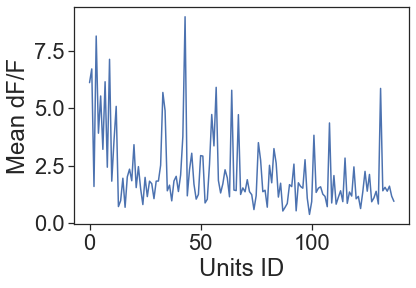

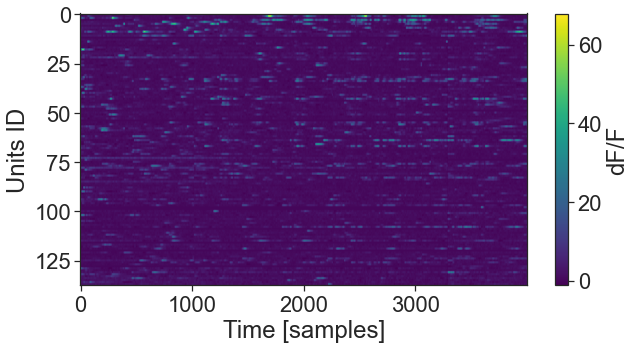

In [10]:
# Plot dFF activity example
plt.figure(); plt.plot(np.mean(dff,1))
plt.ylabel('Mean dF/F'); plt.xlabel('Units ID')
plt.figure(figsize=(10,5))
plt.imshow(dff[:,:4000],cmap='viridis', aspect='auto'); cbar = plt.colorbar()
plt.xlabel('Time [samples]'); plt.ylabel('Units ID')
cbar.set_label('dF/F')

## Cosine distance matrix

In [11]:
# obtain cosine distance matrix
down = 3 # downsampling factor for speeding up calculations
X = dff[:,::down].T
D = cosine_distances(X)

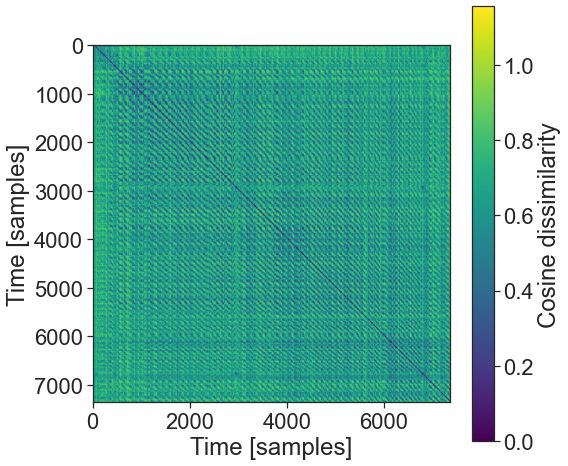

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(D,cmap='viridis'); cbar = plt.colorbar(); cbar.set_label('Cosine dissimilarity')
plt.xlabel('Time [samples]'); plt.ylabel('Time [samples]');

## PCA

In [13]:
### Fit embedding
pca = PCA(n_components=DIMS)
x_embd = pca.fit_transform(X)
x_embd = x_embd / np.max(np.abs(x_embd)) # normalise the values
AXIS_LIM = np.max(x_embd)

<Figure size 432x288 with 0 Axes>

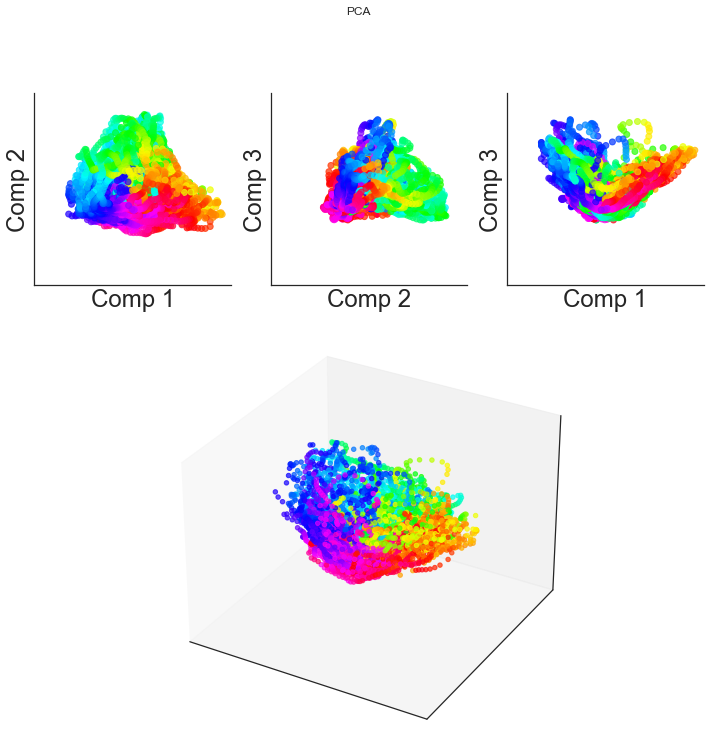

In [14]:
### Plot embedding
plt.set_cmap('hsv') # circular cmap
MIN = -AXIS_LIM
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('PCA')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down][::ds_plt]
scat = ax.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#  saving
plt.savefig(figDirReal+'/PCA_'+LBL+'.png')
plt.savefig(figDirReal+'/PCA_'+LBL+'.svg')

In [24]:
import importlib
importlib.reload(nml)

<module 'NMLfunc' from '/Users/rufusmitchell-heggs/Dropbox/paper - Seig manifolds/Review Paper/code/NMLfunc.py'>

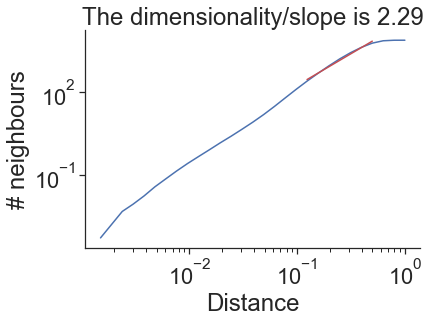

In [25]:
### Intrinsic dimensionality
EMBD = 'PCA'
nstep = 30
Nneigh, radii, p = nml.intrinsic_dimensionality(x_embd, nstep=nstep, metric='euclidean',
                                            fit='std', thr_start=100, thr_fi=5e3)
DIM[EMBD] = p[0]

In [30]:
### OLE  decoding
EMBD = 'PCA'
N = DIMS
cv = 10 # no cv folds
Y = phi[::down].flatten() # angular position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = nml.OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = nml.LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

In [32]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain original high-dim activity and its embedding
    Y = Y_sc[::2,:dim+1]
    X_ = X[::2].copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = nml.new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
#         s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
#         s1 = np.mean((X_[test_idx] - X_rec)**2)
#         s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
#         var_expl_embd[EMBD][dim,c] = 1 - s0/s2
#         var_expl[EMBD][dim,c] = 1 - s1/s2
#         rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


Text(0.5, 1.0, 'Reconstructed')

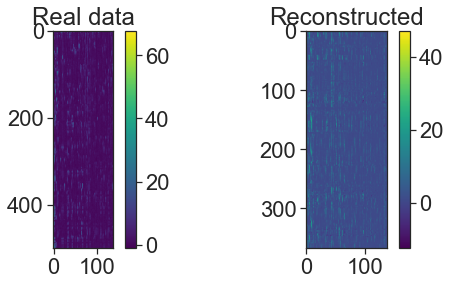

In [33]:
# Visualise a reconstruction example
plt.figure(figsize=(9,4));
plt.subplot(121)
plt.imshow(X_[:500],cmap='viridis'); plt.colorbar()
plt.title('Real data')
plt.subplot(122)
plt.imshow(X_rec[:500],cmap='viridis'); plt.colorbar()
plt.title('Reconstructed')

## CMDSCALE (classic  MDS)

In [34]:
### Fit embedding
x_embd,eig_mds_dff = nml.cmdscale(D)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

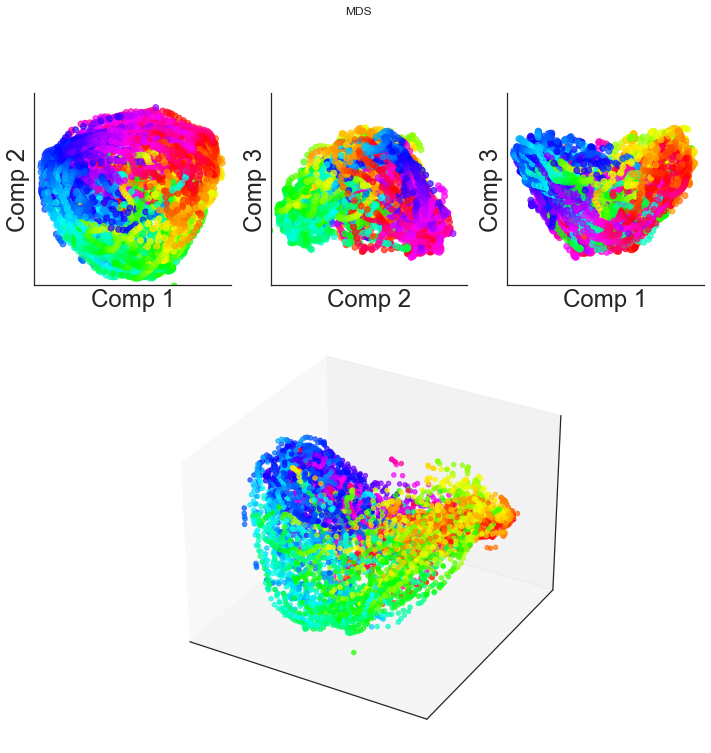

In [35]:
### Plot embedding
plt.set_cmap('hsv') # circular cmap
MIN = -AXIS_LIM
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('MDS')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down][::ds_plt]
scat = ax.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/MDS_'+LBL+'.png')
    plt.savefig(figDirReal+'/MDS_'+LBL+'.svg')
else:
    plt.savefig(figDirSim+'/MDS_'+LBL+'.png')
    plt.savefig(figDirSim+'/MDS_'+LBL+'.svg')

Text(0.5, 0, 'Number of dimensions')

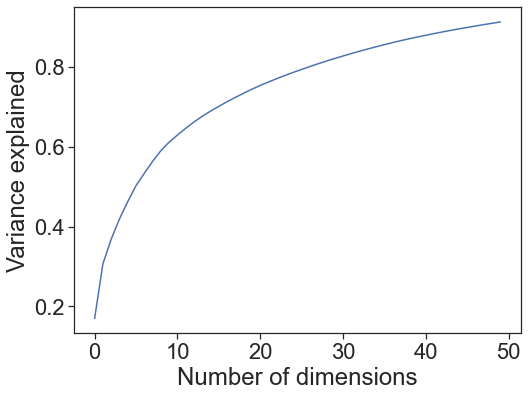

In [36]:
evals_mds_ = eig_mds_dff[eig_mds_dff>0] / np.sum(eig_mds_dff[eig_mds_dff>0])
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(evals_mds_)[:50])
plt.ylabel('Variance explained')
plt.xlabel('Number of dimensions')

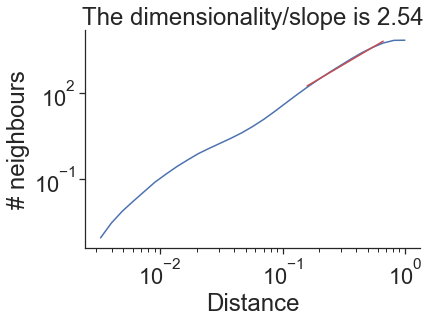

In [37]:
### Dimensionality
EMBD = 'MDS'
nstep = 30
Nneigh, radii, p = nml.intrinsic_dimensionality(x_embd[:,:DIMS], nstep=nstep, metric='euclidean',
                                                fit='std', thr_start=100, thr_fi=5e3)
DIM[EMBD] = p[0]

In [38]:
### OLE  decoding
EMBD = 'MDS'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = nml.OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = nml.LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

In [39]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = nml.new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle,
                                Y[test_idx,:].T, LAMBDA)
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


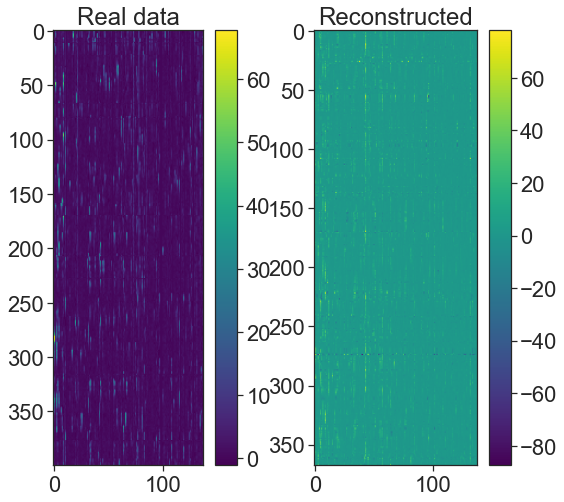

In [40]:
# Visualise a reconstruction example
plt.figure(figsize=(9,8));
plt.subplot(121);
plt.imshow(X_[:400],cmap='viridis'); plt.colorbar()
plt.title('Real data')
plt.subplot(122)
plt.imshow(X_rec[:400],cmap='viridis'); plt.colorbar()
plt.title('Reconstructed');

## ISOMAP

In [41]:
### Fit embedding
COS = 1 # set to 1 for embedding the cosine distance matrix
if COS:
    isomap = Isomap(n_components=DIMS, n_neighbors=40)
    x_embd = isomap.fit_transform(D)
else:
    isomap = Isomap(n_components=DIMS, n_neighbors=40, metric='minkowski')
    x_embd = isomap.fit_transform(X)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

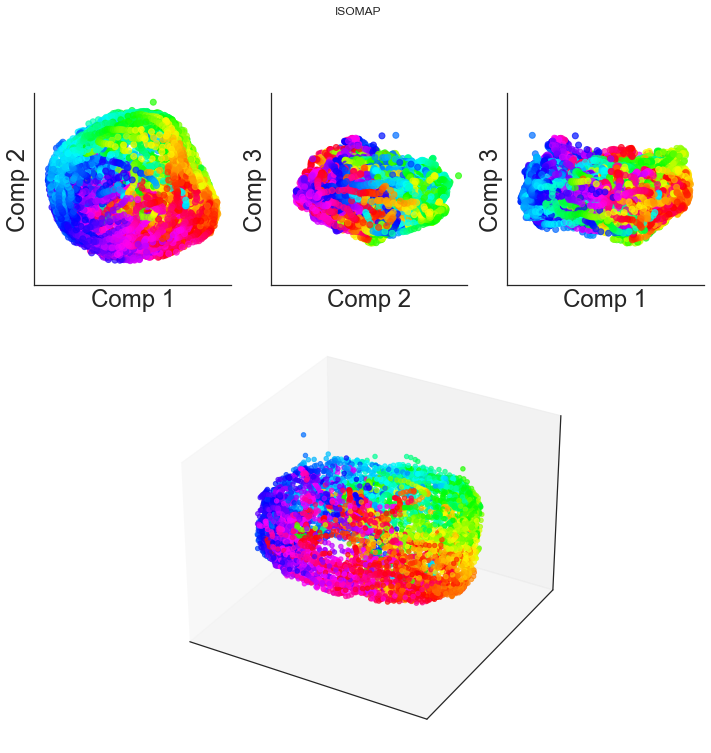

In [42]:
plt.set_cmap('hsv') # circular cmap
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('ISOMAP')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down][::ds_plt]
scat = ax.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlim([-AXIS_LIM,AXIS_LIM])
ax.set_ylim([-AXIS_LIM,AXIS_LIM])
ax.set_zlim([-AXIS_LIM,AXIS_LIM])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#  saving
plt.savefig(figDirReal+'/Isomap_'+LBL+'.png')
plt.savefig(figDirReal+'/Isomap_'+LBL+'.svg')

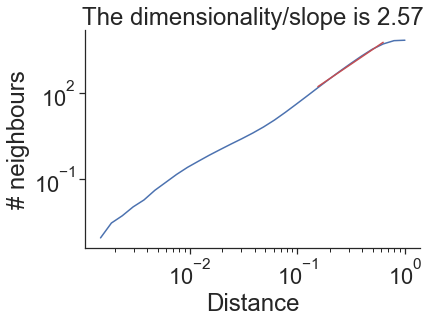

In [43]:
### Dimensionality
EMBD = 'ISO'
nstep = 30
Nneigh, radii, p = nml.intrinsic_dimensionality(x_embd, nstep=nstep, metric='euclidean',
                                                fit='std', thr_start=100, thr_fi=5e3)
DIM[EMBD] = p[0]

In [44]:
### OLE  decoding
EMBD = 'ISO'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = nml.OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = nml.LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

In [45]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    Y = Y_sc[::2,:dim+1]
    X_ = X[::2].copy()
    # cross validation
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = nml.new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle,
                                Y[test_idx,:].T, LAMBDA)
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


Text(0.5, 1.0, 'Reconstructed')

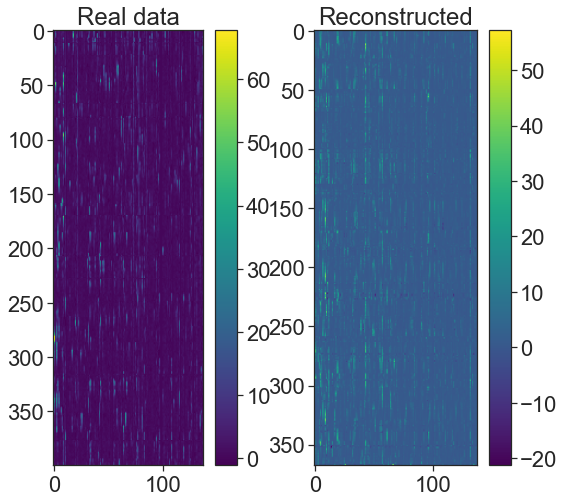

In [46]:
# Visualise a reconstruction example
plt.figure(figsize=(9,8));
plt.subplot(121);
plt.imshow(X_[:400],cmap='viridis'); plt.colorbar()
plt.title('Real data')
plt.subplot(122)
plt.imshow(X_rec[:400],cmap='viridis'); plt.colorbar()
plt.title('Reconstructed')

## LLE

In [47]:
### fit embedding
lle = LocallyLinearEmbedding(n_components=DIMS, n_neighbors=60, method='modified')
x_embd = lle.fit_transform(D)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

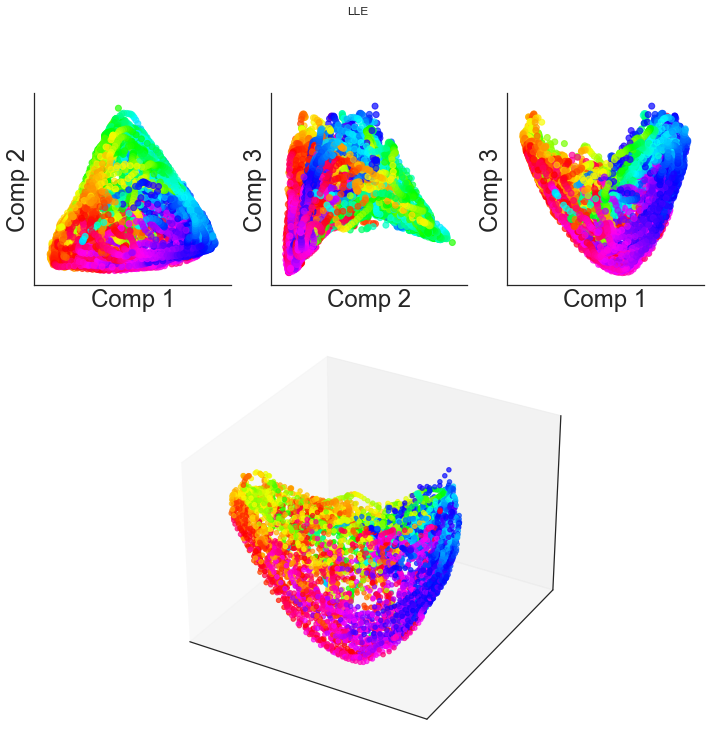

In [48]:
### plotting
plt.set_cmap('hsv') # circular cmap
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('LLE')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down]
scat = ax.scatter(x_embd[:,0], x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
MIN = np.min(x_embd,0)
MAX = np.max(x_embd,0)
ax.set_xlim([MIN[0]-.1,MAX[0]])
ax.set_ylim([MIN[1]-.1,MAX[1]+.1])
ax.set_zlim([MIN[2]-.1,MAX[2]+.1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0], x_embd[:,1], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[0]-.1,MAX[0]+.1]); ax.set_ylim([MIN[1]-.1,MAX[1]+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[1]-.1,MAX[1]+.1]); ax.set_ylim([MIN[2]-.1,MAX[2]+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[0]-.1,MAX[0]+.1]); ax.set_ylim([MIN[2]-.1,MAX[2]+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/LLE_'+LBL+'.png')
    plt.savefig(figDirReal+'/LLE_'+LBL+'.svg')
else:
    plt.savefig(figDirSim+'/LLE_'+LBL+'.png')
    plt.savefig(figDirSim+'/LLE_'+LBL+'.svg')

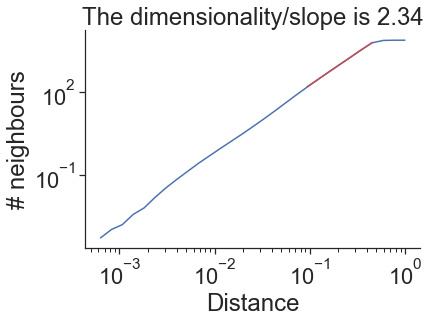

In [50]:
### Dimensionality
EMBD = 'LLE'
nstep = 30
Nneigh, radii, p = nml.intrinsic_dimensionality(x_embd, nstep=nstep, metric='euclidean', fit='std', thr_start=100, thr_fi=5e3)
DIM[EMBD] = p[0]

In [51]:
### OLE  decoding
EMBD = 'LLE'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = nml.OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = nml.LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

In [52]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = nml.new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle,
                                Y[test_idx,:].T, LAMBDA)
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


## Laplacian eigenmaps (Spectral embedding)

In [53]:
# fit embedding
SE = SpectralEmbedding(n_components=DIMS, affinity='nearest_neighbors',
                       n_neighbors=60)
x_embd = SE.fit_transform(D)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

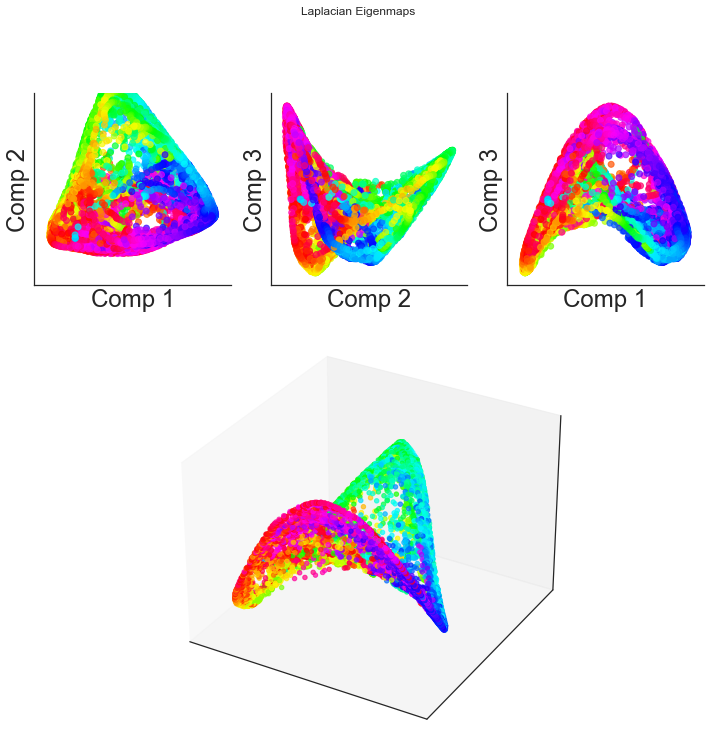

In [54]:
plt.set_cmap('hsv') # circular cmap
MIN = MIN
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('Laplacian Eigenmaps')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down]
scat = ax.scatter(x_embd[:,0], x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
MIN = np.min(x_embd,0)
MAX = np.max(x_embd,0)
ax.set_xlim([MIN[0]-.1,MAX[0]+.1])
ax.set_ylim([MIN[1]-.1,MAX[1]+.1])
ax.set_zlim([MIN[2]-.1,MAX[2]+.1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0], x_embd[:,1], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[0]-.1,MAX[0]+.1]); ax.set_ylim([MIN[0]-.1,MAX[0]+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[1]-.1,MAX[1]+.1]); ax.set_ylim([MIN[2]-.1,MAX[2]+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[0]-.1,MAX[0]+.1]); ax.set_ylim([MIN[2]-.1,MAX[2]+.1])
sns.despine()

#  saving
plt.savefig(figDirReal+'/Laplacian_'+LBL+'.svg')
plt.savefig(figDirReal+'/Laplacian_'+LBL+'.png')

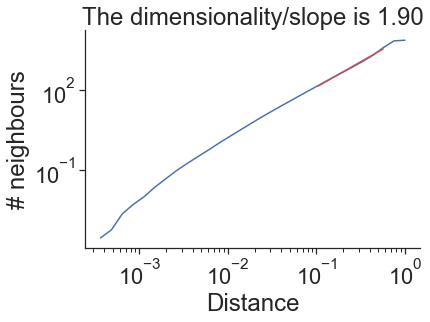

In [55]:
### Dimensionality
EMBD = 'LEM'
nstep = 30
Nneigh, radii, p = nml.intrinsic_dimensionality(x_embd, nstep=nstep, metric='euclidean',
                                                fit='std', thr_start=100, thr_fi=5e3)
DIM[EMBD] = p[0]

In [56]:
### OLE  decoding
EMBD = 'LEM'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = nml.OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = nml.LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

In [57]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = nml.new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle,
                                Y[test_idx,:].T, LAMBDA)
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


## tSNE

In [58]:
# fit embedding
SE = TSNE(n_components=3, metric='euclidean', perplexity=90, random_state=42)
x_embd = SE.fit_transform(X)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

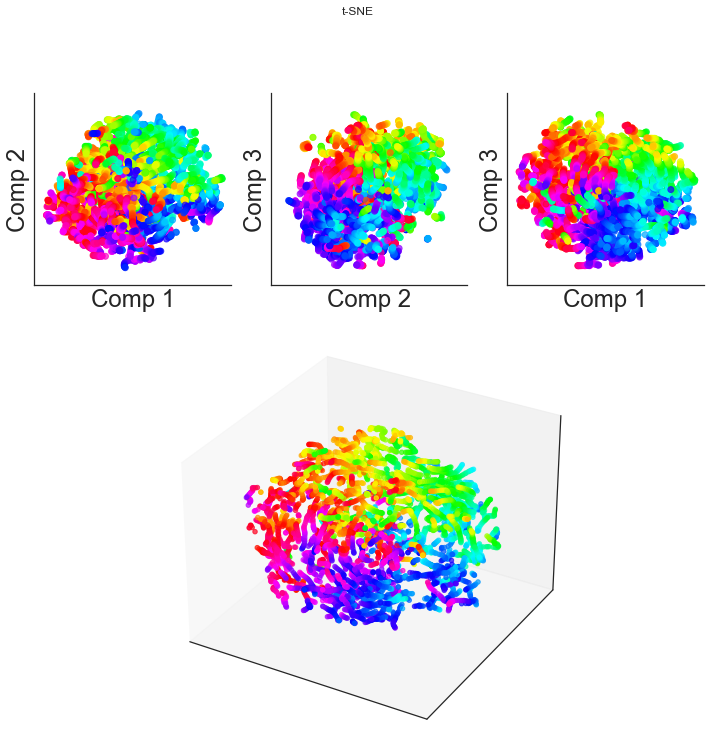

In [59]:
### plotting
plt.set_cmap('hsv') # circular cmap
MIN = -AXIS_LIM
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
cmap = phi[::down][::ds_plt]
plt.suptitle('t-SNE')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
scat = ax.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#  saving
plt.savefig(figDirReal+'/tSNE_'+LBL+'.png')
plt.savefig(figDirReal+'/tSNE_'+LBL+'.svg')

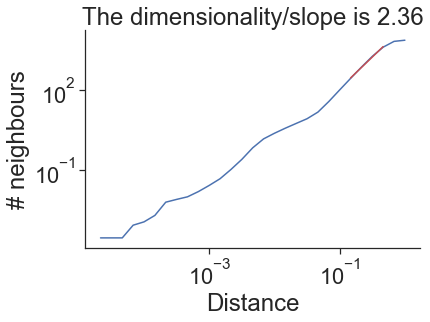

In [60]:
### Dimensionality
EMBD = 't-SNE'
nstep = 30
Nneigh, radii, p = nml.intrinsic_dimensionality(x_embd, nstep=nstep, metric='euclidean',
                                                fit='std', thr_start=100, thr_fi=5e3)
DIM[EMBD] = p[0]

In [62]:
### OLE  decoding
EMBD = 't-SNE'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.ones((N,cv))*np.nan; R[EMBD] = np.ones((N,cv))*np.nan
for n in range(3): # loop over dimensions
    # refit embedding with n+1 dims
    if TYP:
        E = TSNE(n_components=n+1, metric='cosine', perplexity=90, random_state=42)
    else:
        E = TSNE(n_components=n+1, metric='cosine', perplexity=20, random_state=42)
    X_ = E.fit_transform(X)
    X_ = nml.centre_scale(X_)
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = nml.OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = nml.LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1
    print('.')

.
.
.


In [64]:
### Reconstruction error
# scale Y to match X
EMBD = 't-SNE'
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
rec_corr[EMBD] = np.ones((N,cv))*np.nan
for dim in range(3):
    # obtain og high-dim activity and its embedding
    # refit embedding with n+1 dims
    E = TSNE(n_components=dim+1, metric='cosine', perplexity=90, random_state=42)
    Y = E.fit_transform(X)
    Y = nml.centre_scale(Y)
    # scale embedding
    radY = np.percentile(Y-np.mean(Y), 95)
    radX = np.percentile(X-np.mean(X), 95)
    Y_sc = radX/radY * (Y-np.mean(Y))
    Y = Y_sc[::2,:dim+1]
    X_ = X[::2].copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = nml.new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle,
                                Y[test_idx,:].T, LAMBDA)
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.


## UMAP

In [66]:
### Fit embedding
SE = umap.UMAP(n_components=DIMS, metric='cosine', n_neighbors=70, random_state=42)
x_embd = SE.fit_transform(X)
x_embd = nml.centre_scale(x_embd)

<Figure size 432x288 with 0 Axes>

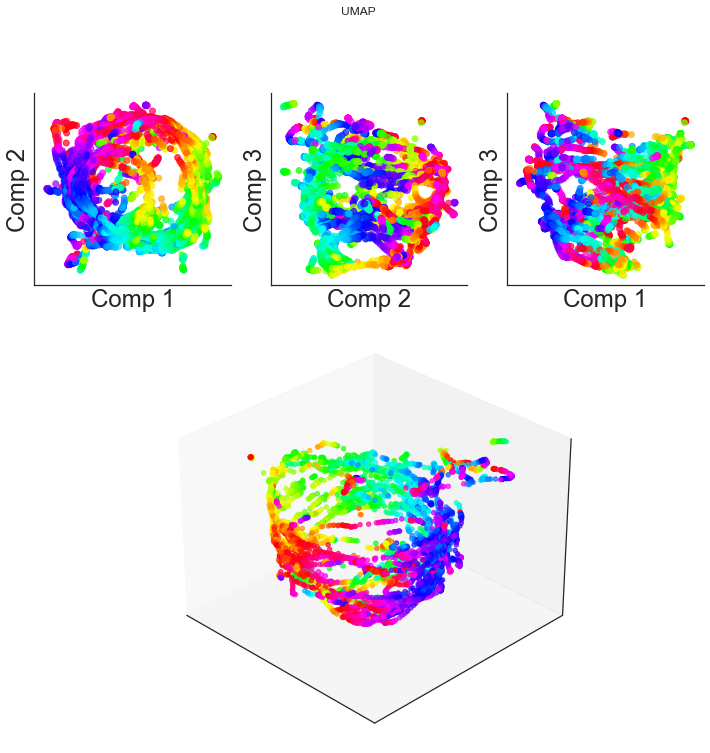

In [67]:
### plotting
plt.set_cmap('hsv') # circular cmap
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
cmap = phi[::down][::ds_plt]
plt.suptitle('UMAP')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
scat = ax.scatter(-x_embd[:,0][::ds_plt], -x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
ax.view_init(elev=30., azim=-45)
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
MIN = np.min(x_embd,0)
MAX = np.max(x_embd,0)
ax.set_xlim([MIN[0]-.1,MAX[0]+.1])
ax.set_ylim([MIN[1]-.1,MAX[1]+.1])
ax.set_zlim([MIN[2]-.1,MAX[2]+.1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0], x_embd[:,1], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[0]-.1,MAX[0]+.1]); ax.set_ylim([MIN[0]-.1,MAX[0]+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[1]-.1,MAX[1]+.1]); ax.set_ylim([MIN[2]-.1,MAX[2]+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[0]-.1,MAX[0]+.1]); ax.set_ylim([MIN[2]-.1,MAX[2]+.1])
sns.despine()

#  saving
plt.savefig(figDirReal+'/UMAP_'+LBL+'.png')
plt.savefig(figDirReal+'/UMAP_'+LBL+'.svg')

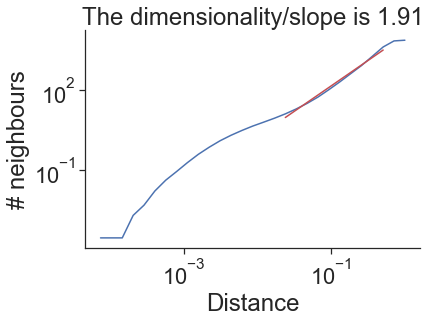

In [68]:
### Dimensionality
EMBD = 'UMAP'
nstep = 30
Nneigh, radii, p = nml.intrinsic_dimensionality(x_embd, nstep=nstep, metric='euclidean',
                                                fit='std', thr_start=10, thr_fi=5e3)
DIM[EMBD] = p[0]

In [70]:
### OLE  decoding
EMBD = 'UMAP'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.ones((N,cv))*np.nan; R[EMBD] = np.ones((N,cv))*np.nan
for n in range(N): # loop over dimensions
    # refit embedding with n+1 dims
    if TYP:
        E = umap.UMAP(n_components=n+1, metric='cosine', n_neighbors=60, random_state=42)
        x_embd = SE.fit_transform(X)
    else:
        E = umap.UMAP(n_components=n+1, metric='cosine', n_neighbors=20, random_state=4)
    X_ = E.fit_transform(X)
    X_ = nml.centre_scale(X_)
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = nml.OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = nml.LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1
    print('.')

.
.
.
.
.


In [71]:
### Reconstruction error
EMBD = 'UMAP'
# 10-fold activity reconstruction
cv = 10
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    # refit embedding with n+1 dims
    E = umap.UMAP(n_components=dim+1, metric='cosine', n_neighbors=60, random_state=42)
    Y = E.fit_transform(X)
    Y = nml.centre_scale(Y)
    # scale embedding
    radY = np.percentile(Y-np.mean(Y), 95)
    radX = np.percentile(X-np.mean(X), 95)
    Y_sc = radX/radY * (Y-np.mean(Y))
    Y = Y_sc[::2,:dim+1]
    X_ = X[::2].copy()
    # cross validation
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = nml.new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T,
                                K_lle, Y[test_idx,:].T, LAMBDA)
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


## Dimensionality

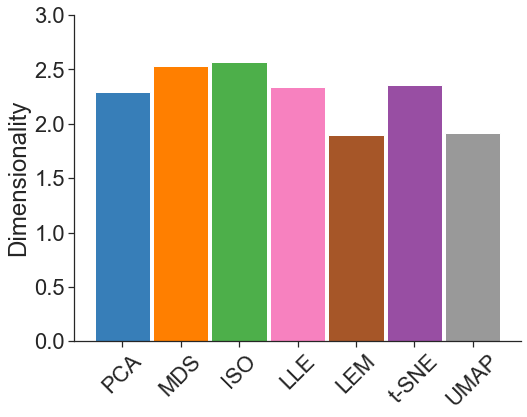

In [72]:
plt.figure(figsize=(8,6))
LBL = 'real'
lbl = ['PCA', 'MDS', 'ISO', 'LLE', 'LEM', 't-SNE', 'UMAP']
for n,e in enumerate(lbl):
    plt.bar(n, DIM[e], width=.95, color=colb[n], label=e)
sns.despine()
# plt.hlines(1, 6.5, -0.5, color='k', linestyle='--')
plt.ylim(0, 3)
plt.ylabel('Dimensionality')
plt.xticks(range(7), lbl, rotation=45);
# saving
# plt.savefig(figDirReal+'/dimensionality_'+LBL+'.svg')
# plt.savefig(figDirReal+'/dimensionality_'+LBL+'.png')

## Linear Decoding - OLE

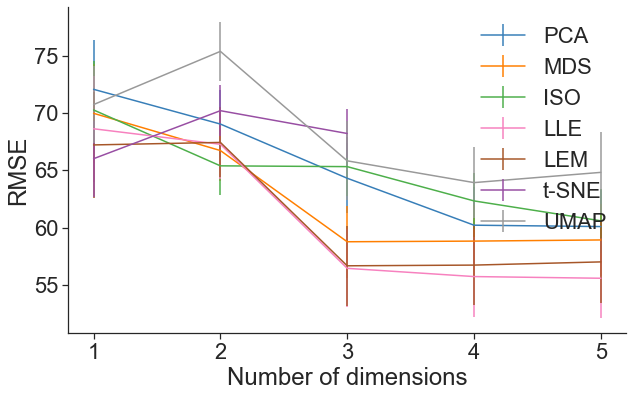

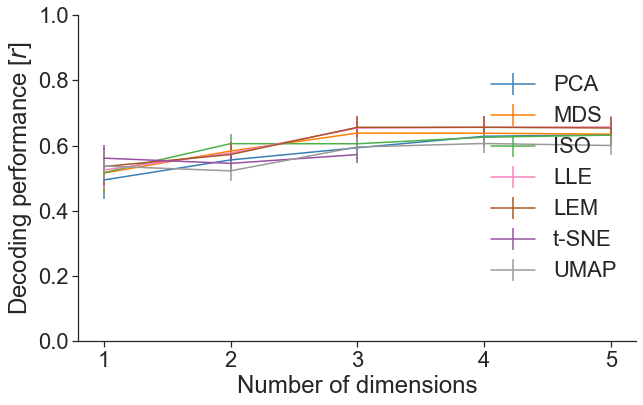

In [73]:
sns.set(style='ticks', font_scale=2)
plt.figure(figsize=(10,6))
for n,k in enumerate(R):
    sem = stats.sem(RMSE[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(RMSE[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.legend(frameon=False, loc=1)
plt.xticks(range(1,DIMS+1))
plt.ylabel('RMSE')
plt.xlabel('Number of dimensions')
sns.despine()
# saving
plt.savefig(figDirReal+'/decode_rmseErr_'+LBL+'.svg')
plt.savefig(figDirReal+'/decode_rmseErr_'+LBL+'.png')

plt.figure(figsize=(10,6))
for n,k in enumerate(R):
    sem = stats.sem(R[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(R[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.ylim(0,1)
plt.xticks(range(1,DIMS+1))
plt.ylabel('Decoding performance [$r$]')
plt.xlabel('Number of dimensions')
plt.legend(frameon=False, loc=5)
sns.despine()
# saving
plt.savefig(figDirReal+'/decode_corrErr_'+LBL+'.svg')
plt.savefig(figDirReal+'/decode_corrErr_'+LBL+'.png')

### Variance explained / reconstruction error

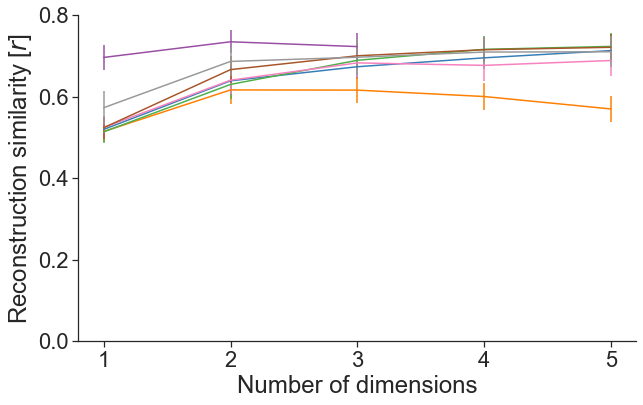

In [79]:
# Non-linear  variance explained
keys = list(rec_corr.keys())
# plt.figure(figsize=(10,6))
# for n,k in enumerate(keys):
#     sem = stats.sem(var_expl[k],1, nan_policy='omit')
#     plt.errorbar(range(1,DIMS+1), np.nanmean(var_expl[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
# plt.legend(frameon=False,loc=4)
# if TYP: plt.ylim(0,.6)
# else: plt.ylim(0,.7)
# plt.xticks(range(1,DIMS+1))
# plt.ylabel('Reconstruction score')
# plt.xlabel('Number of dimensions')
# sns.despine()
# # saving
# plt.savefig(figDirReal+'/var_expl_'+LBL+'.svg')
# plt.savefig(figDirReal+'/var_expl_'+LBL+'.png')

# # Reconstuction error
# plt.figure(figsize=(10,6))
# for n,k in enumerate(keys):
#     sem = stats.sem(rec_err[k],1, nan_policy='omit')
#     plt.errorbar(range(1,DIMS+1), np.nanmean(rec_err[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
# plt.ylim(0)
# plt.ylabel('Reconstruction RMSE')
# plt.xlabel('Number of dimensions')
# plt.xticks(range(1,DIMS+1))
# sns.despine()
# # saving
# plt.savefig(figDirReal+'/rec_err_'+LBL+'.svg')
# plt.savefig(figDirReal+'/rec_err_'+LBL+'.png')
    
# Reconstuction correlation
plt.figure(figsize=(10,6))
for n,k in enumerate(keys):
    sem = stats.sem(rec_corr[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(rec_corr[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.ylim(0,.8)
plt.ylabel('Reconstruction similarity [$r$]')
plt.xlabel('Number of dimensions')
plt.xticks(range(1,DIMS+1))
sns.despine()
# saving
plt.savefig(figDirReal+'/rec_corr_'+LBL+'.svg')
plt.savefig(figDirReal+'/rec_corr_'+LBL+'.png')